# -- 🚗 Used Car Price Prediction --

# 1. EDA  
Bu notebookta **keşifsel veri analizi (EDA)** adımları yer almaktadır.  
Amaç, veri setini tanımak, değişkenlerin dağılımlarını incelemek ve sonraki modelleme adımlarına yön verecek bulgular elde etmektir.

## 1.1. Veri Seti Genel Özellikleri
- Veri Seti:  **Kaggle üzerinde paylaşılan “Used Cars Dataset v2”** adlı ikinci el araç fiyatları veri setidir. Veri seti, farklı marka ve modellerdeki araçların teknik ve ticari özelliklerini içermekte olup, araç fiyat tahmini problemi için oldukça uygun bir yapıya sahiptir.

- Temel kolonlar:
  - **Brand**: Araç markası  
  - **model**: Araç modeli  
  - **Year**: Üretim yılı  
  - **Age**: Araç yaşı  
  - **kmDriven**: Kat edilen kilometre  
  - **Transmission**: Vites tipi (Manual / Automatic)  
  - **Owner**: İlk/ikinci el bilgisi  
  - **FuelType**: Yakıt türü  
  - **PostedDate**: İlan tarihi  
  - **AdditionInfo**: Serbest metin açıklama  
  - **AskPrice**: İstenen satış fiyatı  

Bu notebook **sadece EDA** içerir; modelleme, feature engineering ve pipeline adımları diğer notebooklarda yer almaktadır.


In [1]:
# Kütüphanelerin Yüklenmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)


In [2]:
# Veri seti
df = pd.read_csv("/kaggle/input/automl8/used_cars_dataset_v2.csv")

# İlk gözlem
df.head()

,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice
0,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,Nov-24,"Honda City v teck in mint condition, valid gen...","₹ 1,95,000"
1,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,Jul-24,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","₹ 3,75,000"
2,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,Nov-24,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","₹ 1,84,999"
3,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,Nov-24,Maruti Suzuki Swift 2017 Diesel Good Condition,"₹ 5,65,000"
4,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,Nov-24,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","₹ 6,85,000"


In [3]:
# Genel bilgi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Brand         14993 non-null  object
 1   model         14993 non-null  object
 2   Year          14993 non-null  int64 
 3   Age           14993 non-null  int64 
 4   kmDriven      14905 non-null  object
 5   Transmission  14993 non-null  object
 6   Owner         14993 non-null  object
 7   FuelType      14993 non-null  object
 8   PostedDate    14993 non-null  object
 9   AdditionInfo  14993 non-null  object
 10  AskPrice      14993 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [4]:
# Temel istatistikler (sayısal + kategorik)
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,14993,43,Maruti Suzuki,4615,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,14993,436,Wagon-R,616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,14993.0,NaN,NaN,NaN,2016.32215,4.343017,1900.0,2014.0,2017.0,2019.0,2024.0
Age,14993.0,NaN,NaN,NaN,7.67785,4.343017,0.0,5.0,7.0,10.0,124.0
kmDriven,14905,2718,"65,000 km",295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,14993,2,Automatic,7618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner,14993,2,second,7794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelType,14993,4,Petrol,5822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostedDate,14993,13,Nov-24,13251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdditionInfo,14993,10676,"BMW 3 Series GT 320d Luxury Line, 2015, Diesel",30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Eksik değer analizi
df.isnull().sum()

Brand            0
model            0
Year             0
Age              0
kmDriven        88
Transmission     0
Owner            0
FuelType         0
PostedDate       0
AdditionInfo     0
AskPrice         0
dtype: int64

## 1.2. Veri Temizliği

- kmDriven ve AskPrice Temizliği

`kmDriven` ve `AskPrice` değişkenleri string formatında tutulduğundan, hem EDA'da daha sağlıklı analiz yapabilmek hem de sonraki modelleme adımlarında kullanabilmek için sayısal forma dönüştürülmüştür.


In [6]:
# kmDriven temizleme
def clean_km(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower().replace("km", "").replace(",", "").strip()
    try:
        return float(x)
    except ValueError:
        return np.nan

df["kmDriven_clean"] = df["kmDriven"].apply(clean_km)

# AskPrice temizleme
def clean_price(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    x = (
        x.replace("₹", "")
         .replace(",", "")
         .replace("rs.", "")
         .replace("rs", "")
         .strip())
    try:
        return float(x)
    except ValueError:
        return np.nan

df["AskPrice_clean"] = df["AskPrice"].apply(clean_price)

df[["kmDriven", "kmDriven_clean", "AskPrice", "AskPrice_clean"]].head()


,kmDriven,kmDriven_clean,AskPrice,AskPrice_clean
0,"98,000 km",98000.0,"₹ 1,95,000",195000.0
1,190000.0 km,190000.0,"₹ 3,75,000",375000.0
2,"77,246 km",77246.0,"₹ 1,84,999",184999.0
3,"83,500 km",83500.0,"₹ 5,65,000",565000.0
4,"45,000 km",45000.0,"₹ 6,85,000",685000.0



## 1.3. Sayısal Değişken Dağılımları

Aşağıda üretim yılı, yaş, kilometre ve fiyat değişkenlerinin dağılımları gösterilmiştir.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

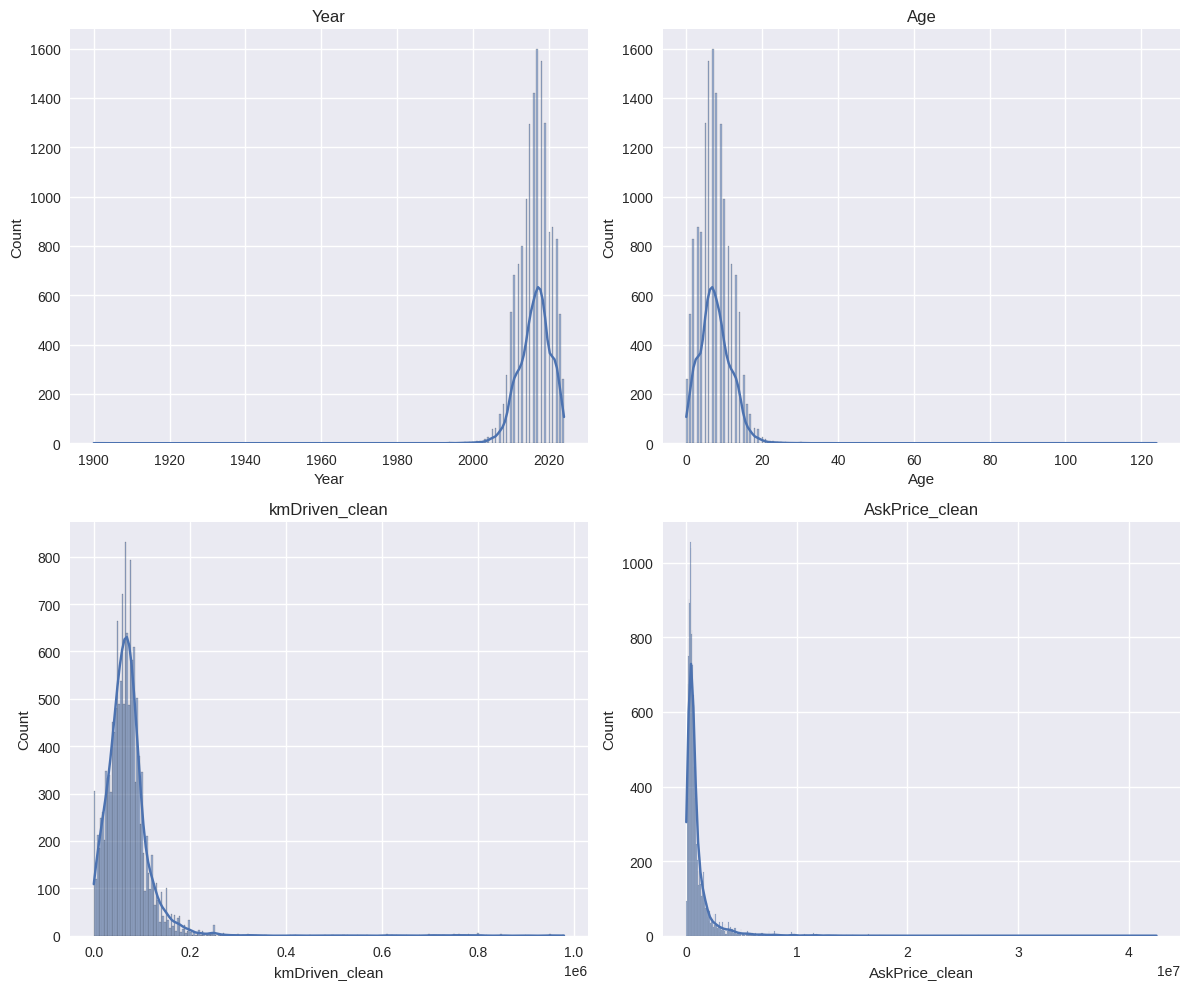

In [7]:
# Sayısal Değişken Dağılımları

numeric_cols = ["Year", "Age", "kmDriven_clean", "AskPrice_clean"]

plt.figure(figsize=(12, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()



## 1.4. Korelasyon Analizi

Sayısal değişkenler arasındaki ilişkiyi görmek için korelasyon matrisi incelenmiştir.


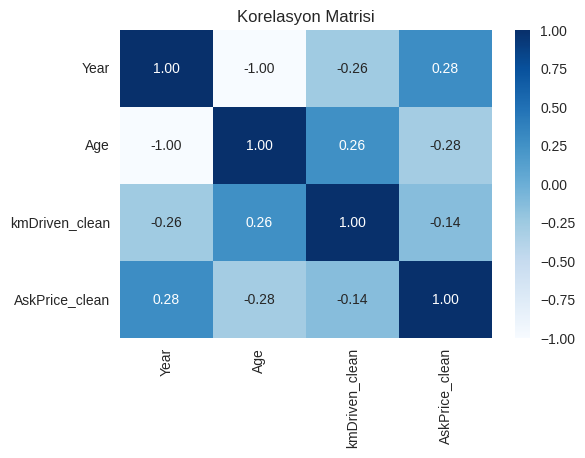

,Year,Age,kmDriven_clean,AskPrice_clean
Year,1.000000,-1.000000,-0.264577,0.282384
Age,-1.000000,1.000000,0.264577,-0.282384
kmDriven_clean,-0.264577,0.264577,1.000000,-0.135338
AskPrice_clean,0.282384,-0.282384,-0.135338,1.000000


In [8]:
#Korelasyon

corr_cols = ["Year", "Age", "kmDriven_clean", "AskPrice_clean"]
corr = df[corr_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

corr



## 1.5. Kategorik Değişkenler ve Fiyat İlişkisi

Aşağıdaki kutu grafikleri, hedef değişken olan `AskPrice_clean` ile bazı kategorik değişkenlerin ilişkisini göstermektedir.


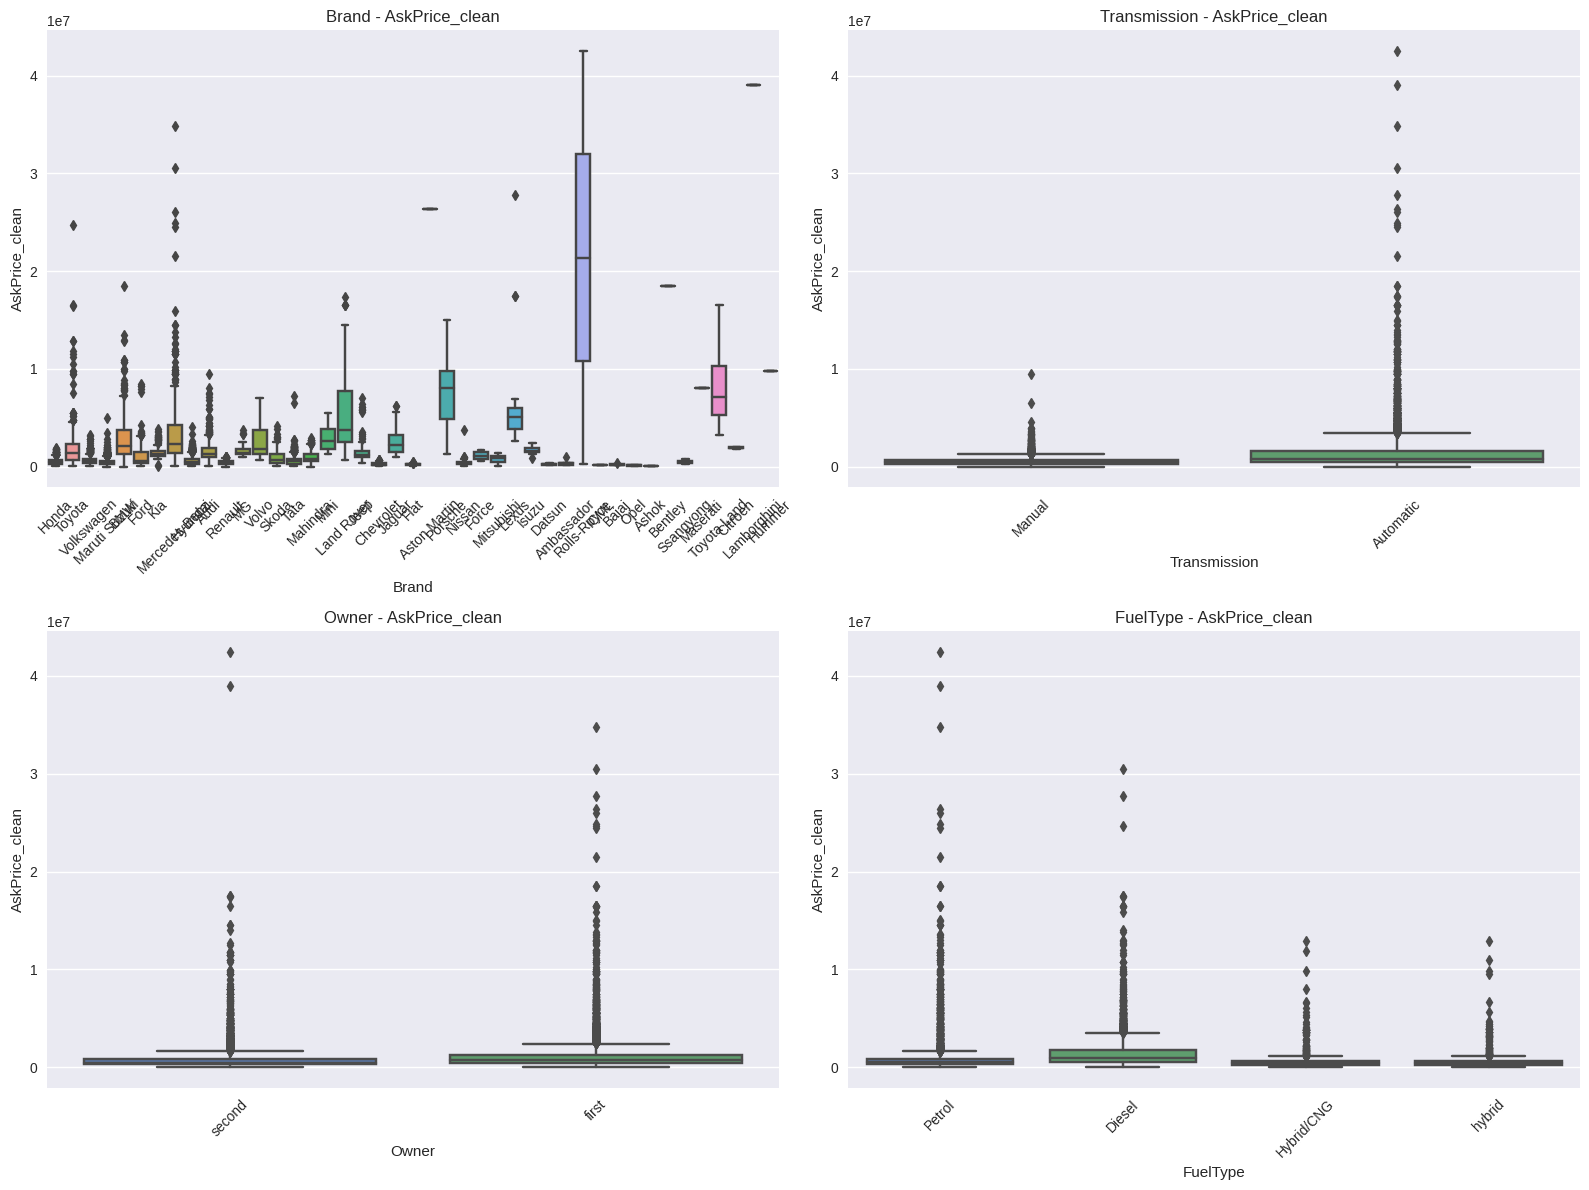

In [9]:
# Kategorik Değişkenler ve Fiyat İlişkisi

cat_cols_plot = ["Brand", "Transmission", "Owner", "FuelType"]

plt.figure(figsize=(16, 12))

for i, col in enumerate(cat_cols_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x=col, y="AskPrice_clean")
    plt.xticks(rotation=45)
    plt.title(f"{col} - AskPrice_clean")

plt.tight_layout()
plt.show()



## 1.6. EDA Özet Bulgular

- Veri seti yaklaşık 15 bin gözlem ve 11 ana kolondan oluşmaktadır.
- Eksik değerler yalnızca `kmDriven` değişkeninde sınırlı sayıda gözlenmiş, diğer kolonlarda eksik değer bulunmamıştır.
- `kmDriven` ve `AskPrice` string formatından sayısala dönüştürülerek `kmDriven_clean` ve `AskPrice_clean` kolonları oluşturulmuştur.
- Sayısal dağılımlar sağa çarpıktır; özellikle fiyat ve kilometre değişkenlerinde uzun kuyruklar vardır.
- Korelasyon analizinde:
  - `Year` ile `AskPrice_clean` arasında pozitif,
  - `Age` ile `AskPrice_clean` arasında negatif ilişki görülmüştür.
- Kutu grafikleri, marka, vites tipi, sahiplik durumu ve yakıt türünün fiyat üzerinde belirgin farklılıklar yarattığını göstermektedir.

Bu notebook, veri hakkında genel bir sezgi kazandırmak ve sonraki adımlarda uygulanacak
feature engineering ve modelleme süreçlerine temel oluşturmak amacıyla hazırlanmıştır.
